In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # Enable CPU fallback for MPS
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Disable high watermark for MPS
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
import logging
import matplotlib.pyplot as plt

from tqdm import tqdm

from config import Configurator
from data import NeuralDataset, collate_transducer, download_data, get_dataframes
from training import Trainer, EarlyStopping
from losses import RNNTLoss, FastRNNTLoss
from models import MyEncoder, MyPredictor, MyJoiner, RNNT, predict_on_sample

Config = Configurator()
path = Config.DATA_PATH
device = Config.DEVICE

In [3]:
train_df, val_df = get_dataframes(path, debug=Config.DEBUG)

Loading 1 train files in parallel...


Processing Train: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Loading 1 val files in parallel...


Processing Val: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


In [4]:
# ------------------------ Dataset and Dataloader ------------------------
smoothing = True

train_dataset = NeuralDataset(train_df, augment=True, smoothing=smoothing)
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda b: collate_transducer(b, batch_first=Config.BATCH_FIRST)
)

val_dataset = NeuralDataset(val_df, augment=False, smoothing=smoothing)
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: collate_transducer(b, batch_first=Config.BATCH_FIRST)
)

In [1]:
encoder = MyEncoder(input_dim=Config.FEATURE_LEN, hidden_dim=256, layers=4, dropout=0.2, conformer=True)
predictor = MyPredictor(vocab_size=Config.VOCAB_SIZE, hidden_dim=256, blank_id=Config.BLANK_ID)
joiner = MyJoiner(input_dim=256, output_dim=Config.VOCAB_SIZE)
model = RNNT(encoder, predictor, joiner).to(device)

# loss = RNNTLoss(blank_id=Config.BLANK_ID)
loss = FastRNNTLoss(blank_id=Config.BLANK_ID)

model_checkpoint_path = str(Path(Config.MODEL_PATH) / f"{model}_{loss}_{Config.MODEL_STR}")

if not Config.TRAIN:
    try:
        model.load_state_dict(torch.load(model_checkpoint_path, map_location=device, weights_only=True))
        print(f"Loaded model from {model_checkpoint_path}")
    except Exception as e:
        print(f"Could not load model: {e}")

# number of model parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params:,} total parameters.")
print(f"Model has {num_trainable_params:,} trainable parameters.")
print(model.describe())

NameError: name 'MyEncoder' is not defined

In [ ]:
num_epochs = 100
lr = 3e-3

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=1e-2
)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    anneal_strategy='cos'
)

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    loss_fn=loss,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs,
    early_stop=EarlyStopping(patience=10, min_delta=1e-3, path="./test_model.pt"),
    batch_first=Config.BATCH_FIRST,
)

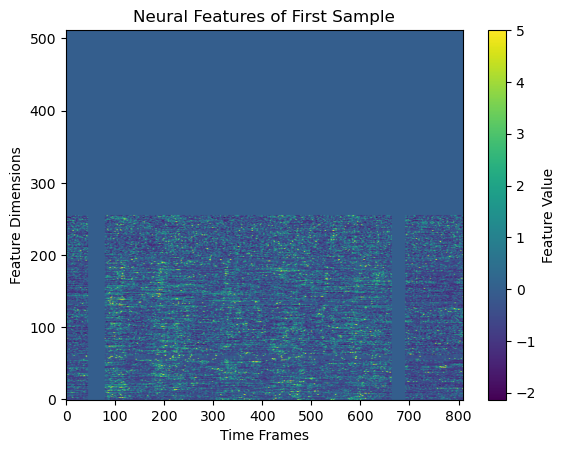

In [15]:
rnd_i = random.randint(0, len(train_dataset) - 1)
x, y = train_dataset[rnd_i]
first_sample_features = x.cpu().numpy()
plt.imshow(first_sample_features.T, aspect='auto', origin='lower')
plt.title("Neural Features of First Sample")
plt.xlabel("Time Frames")
plt.ylabel("Feature Dimensions")
plt.colorbar(label="Feature Value")
plt.show()